# XGBoost

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_curve
import kagglehub

# 一般參數
RANDOM_SEED = 42
TEST_SIZE = 0.3

# 載入資料集
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")
data['Class'] = data['Class'].astype(int)
data.drop('Time', axis=1, inplace=True)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# 顯示類別比例
fraud = data[data['Class'] == 1]
nonfraud = data[data['Class'] == 0]
print(f'Fraudulent:{len(fraud)}, non-fraudulent:{len(nonfraud)}')
print(f'the positive class (frauds) percentage: {len(fraud)/(len(fraud)+len(nonfraud))*100:.3f}%')

# 特徵與標籤
X = data.drop(columns=['Class']).to_numpy()
Y = data['Class'].to_numpy()

# 切分訓練與測試集
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# 標準化
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# 建立 XGBoost 模型
xgb_model = XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    subsample=0.8,
    scale_pos_weight=2.5,
    eval_metric='logloss',
    tree_method='hist',
    random_state=RANDOM_SEED
)

# 訓練模型
xgb_model.fit(X_train_std, y_train)

# 模型機率預測
y_prob = xgb_model.predict_proba(X_test_std)[:, 1]

threshold = 0.4031
y_pred_custom = (y_prob > threshold).astype(int)

# 分類報告
print(classification_report(y_test, y_pred_custom))

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = f1.argmax()
best_threshold = thresholds[best_idx]

print(f"\n🔍 Best Threshold based on F1: {best_threshold:.4f}, F1 = {f1[best_idx]:.4f}")

#Autoencoder

Epoch 1/100 - Train Loss: 1607.4813 | Val Loss: 0.4661
Epoch 2/100 - Train Loss: 1209.4325 | Val Loss: 0.3989
Epoch 3/100 - Train Loss: 1078.8343 | Val Loss: 0.3638
Epoch 4/100 - Train Loss: 992.1469 | Val Loss: 0.3399
Epoch 5/100 - Train Loss: 937.6718 | Val Loss: 0.3279
Epoch 6/100 - Train Loss: 906.2909 | Val Loss: 0.3186
Epoch 7/100 - Train Loss: 882.8205 | Val Loss: 0.3130
Epoch 8/100 - Train Loss: 864.8046 | Val Loss: 0.3062
Epoch 9/100 - Train Loss: 849.6127 | Val Loss: 0.3005
Epoch 10/100 - Train Loss: 831.9480 | Val Loss: 0.2970
Epoch 11/100 - Train Loss: 821.7574 | Val Loss: 0.2906
Epoch 12/100 - Train Loss: 809.3690 | Val Loss: 0.2878
Epoch 13/100 - Train Loss: 799.7795 | Val Loss: 0.2850
Epoch 14/100 - Train Loss: 792.8719 | Val Loss: 0.2825
Epoch 15/100 - Train Loss: 784.1484 | Val Loss: 0.2843
Epoch 16/100 - Train Loss: 780.9826 | Val Loss: 0.2776
Epoch 17/100 - Train Loss: 773.9783 | Val Loss: 0.2751
Epoch 18/100 - Train Loss: 771.0131 | Val Loss: 0.2739
Epoch 19/100 - T

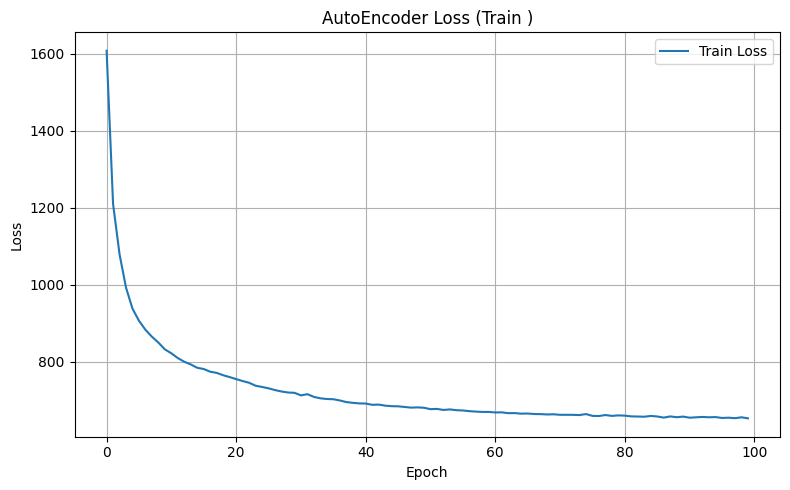

In [1]:
# Re-import necessary modules after kernel reset
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt

# 資料預處理
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")
data.drop('Time', axis=1, inplace=True)
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
X = data.drop(columns=['Class']).values
Y = data['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)
X_train_auto = X_train[y_train == 0]

# 轉 tensor
X_train_auto_tensor = torch.tensor(X_train_auto, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# AutoEncoder 模型
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super().__init__()
        hidden_dim = encoding_dim // 2
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.Tanh(),
            nn.Linear(encoding_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, encoding_dim),
            nn.Tanh(),
            nn.Linear(encoding_dim, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 設定
input_dim = X_train.shape[1]
encoding_dim = 17
model = AutoEncoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

val_size = int(0.1 * X_train_auto.shape[0])
train_data = X_train_auto[:-val_size]
val_data = X_train_auto[-val_size:]

# 轉換為 Tensor
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)

EPOCHS = 100
BATCH_SIZE = 64
train_losses, val_losses = [], []

#訓練迴圈
for epoch in range(EPOCHS):
    model.train()
    perm = torch.randperm(train_tensor.size(0))
    epoch_train_loss = 0

    for i in range(0, len(perm), BATCH_SIZE):
        indices = perm[i:i + BATCH_SIZE]
        batch = train_tensor[indices]
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # 驗證階段
    model.eval()
    with torch.no_grad():
        val_output = model(val_tensor)
        val_loss = criterion(val_output, val_tensor).item()

    # 記錄
    avg_train_loss = epoch_train_loss / (len(perm) // BATCH_SIZE)
    train_losses.append(epoch_train_loss)
    val_losses.append(val_loss)

    #顯示進度
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {val_loss:.4f}")
with torch.no_grad():
    X_test_pred = model(X_test_tensor).numpy()
mse = np.mean((X_test - X_test_pred) ** 2, axis=1)

# 評估函數
def evaluation(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n{model_name} Evaluation:")
    print("===" * 15)
    print("         Accuracy:", accuracy)
    print("  Precision Score:", precision)
    print("     Recall Score:", recall)
    print("         F1 Score:", f1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, mse)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"\nBest F1 Threshold: {best_threshold:.6f}")
print(f"Precision: {precision[best_idx]:.4f}, Recall: {recall[best_idx]:.4f}, F1: {f1_scores[best_idx]:.4f}")

#分類結果
y_pred = (mse > best_threshold).astype(int)
print(best_threshold)

evaluation(y_test, y_pred, model_name=f"AutoEncoder)")

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("AutoEncoder Loss (Train )")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()